In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import Data

In [103]:
column_names = ['Year','Title', 'Origin', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot']
data = pd.read_csv('wiki_movie_plots_deduped.csv', names=column_names, skiprows=10000, nrows=4000)
data.head()

,Year,Title,Origin,Director,Cast,Genre,Wiki Page,Plot
0,1982,Parasite,American,Charles Band,"Demi Moore, Robert Glaudini",horror,https://en.wikipedia.org/wiki/Parasite_(film),"In the near future, an atomic disaster has red..."
1,1982,Partners,American,James Burrows,"John Hurt, Ryan O'Neal",comedy,https://en.wikipedia.org/wiki/Partners_(1982_f...,After a series of murders in Los Angeles's gay...
2,1982,Personal Best,American,Robert Towne,"Mariel Hemingway, Scott Glenn, Patrice Donnelly","drama, sports",https://en.wikipedia.org/wiki/Personal_Best_(f...,Chris Cahill is a young athlete who competes u...
3,1982,Poltergeist,American,Tobe Hooper,"Craig T. Nelson, Beatrice Straight, Dominique ...",horror,https://en.wikipedia.org/wiki/Poltergeist_(198...,Steven and Diane Freeling live a quiet life in...
4,1982,Porky's,American,Bob Clark,"Kim Cattrall, Mark Herrier, Wyatt Knight",comedy,https://en.wikipedia.org/wiki/Porky%27s,A group of Florida high school students plan o...


# Removing Columns

In [104]:
columns_to_remove = ['Cast','Wiki Page','Director']
data = data.drop(columns_to_remove, axis=1)
data.head()

,Year,Title,Origin,Genre,Plot
0,1982,Parasite,American,horror,"In the near future, an atomic disaster has red..."
1,1982,Partners,American,comedy,After a series of murders in Los Angeles's gay...
2,1982,Personal Best,American,"drama, sports",Chris Cahill is a young athlete who competes u...
3,1982,Poltergeist,American,horror,Steven and Diane Freeling live a quiet life in...
4,1982,Porky's,American,comedy,A group of Florida high school students plan o...


# Analysing data

In [105]:
print(
    data.shape,
    data.columns
)

(4000, 5) Index(['Year', 'Title', 'Origin', 'Genre', 'Plot'], dtype='object')


# Counting NaN's and unkown's

In [106]:
columns = data.columns
data.dtypes

Year       int64
Title     object
Origin    object
Genre     object
Plot      object
dtype: object

In [107]:
for column in columns.drop('Genre'):
    print(column, end=" ")
    try:
        print(data[data[column] == 'unknown'].shape)
    except TypeError:
        print(data[data[column] == np.NaN].shape)

Year (0, 5)
Title (0, 5)
Origin (0, 5)
Plot (0, 5)


/home/gustavo/Envs/machine/lib/python3.5/site-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## Defining Methods for data treatment

## Feature Engineering

In [108]:
def unknown_to_nan(information):
    result = ''
    if str(information).lower() == "unknown":
        result = np.NaN
    else:
        result = information
    return result

In [109]:
for column in columns:
    data[column] = data[column].apply(unknown_to_nan)

In [213]:
data['Genre'] = data['Genre'].astype('category')
data['Origin'] = data['Origin'].astype('category')

In [117]:
data['Genre'].fillna('unknown', inplace=True)

In [118]:
data['Genre'].value_counts()

comedy                        962
drama                         893
horror                        272
action                        260
thriller                      181
crime drama                   143
science fiction               140
family                         76
animated                       66
fantasy                        63
sci-fi                         60
unknown                        56
romantic comedy                53
comedy, drama                  47
adventure                      47
biography                      36
romance                        35
crime                          33
animation                      32
suspense                       32
drama, biography               25
western                        21
musical                        19
war                            15
animated film                  14
mystery                        13
drama, comedy                  12
rom com                        11
biography, drama               11
drama, war    

## Let's transform this 2 name categories into 1 name only

In [168]:
def return_only_one_category(category):
    """
    If the category has two categories, like: `comedy, drama`, then
    return only the first one. 
    
    Also, return the first category if the category is something like: 
    `family adventure`
    """
    return category.split(' ')[0].strip('.,')

In [169]:
data['Genre'] = data['Genre'].apply(lambda x: return_only_one_category(x))

In [170]:
data['Genre'].value_counts().head(10)

comedy      1067
drama        963
action       298
horror       288
crime        194
thriller     184
science      156
family        91
animated      84
sci-fi        68
Name: Genre, dtype: int64

## Let's see some data on Plots

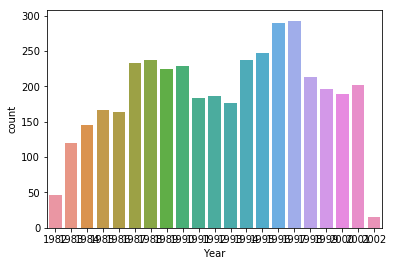

In [154]:
sns.countplot(x='Year', data=data)

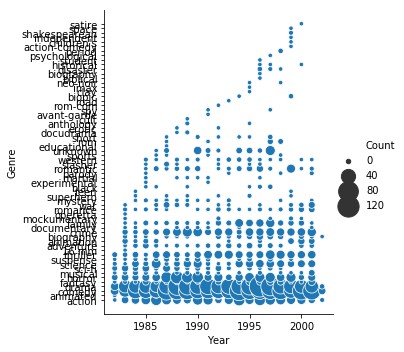

In [182]:
_d = data.groupby(['Year','Genre']).count().reset_index().rename(columns={'Title':'Count'})[['Year','Genre','Count']]

sns.relplot(x='Year', y='Genre', size='Count', data=_d, sizes=(20,450))

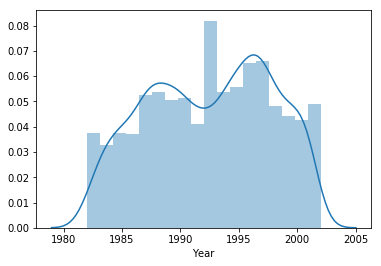

In [194]:
sns.distplot(data['Year'])

In [195]:
from sklearn.decomposition import NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, OneHotEncoder, FunctionTransformer,StandardScaler 

# Creating MegaPipeline to treat heterogeneous features

In [184]:
#Rememb
data.head()

,Year,Title,Origin,Genre,Plot
0,1982,Parasite,American,horror,"In the near future, an atomic disaster has red..."
1,1982,Partners,American,comedy,After a series of murders in Los Angeles's gay...
2,1982,Personal Best,American,drama,Chris Cahill is a young athlete who competes u...
3,1982,Poltergeist,American,horror,Steven and Diane Freeling live a quiet life in...
4,1982,Porky's,American,comedy,A group of Florida high school students plan o...


In [ ]:
categorical_data

In [252]:
def get_text_features(dataframe):
    return dataframe[['Title','Plot']]

def get_categorical_data(dataframe):
    return pd.get_dummies(dataframe[['Origin','Genre']])

def get_numerical_data(dataframe):
    return dataframe[['Year']]

text_data = Pipeline([
    ('selector', FunctionTransformer(get_text_features, validate=False)),
    ('tfidf', TfidfVectorizer(token_pattern=r'\w+', ngram_range=(1,2))),
#     ('dimension_reduction', SelectKBest(chi2, k=300))
     ])
    
categorical_data = Pipeline([
    ('selector', FunctionTransformer(get_categorical_data, validate=False))
])
numerical_data = Pipeline([
    ('selector', FunctionTransformer(get_numerical_data, validate=False)),
    ('scaler', StandardScaler())    
])
    
feature_union = FeatureUnion(
    transformer_list=[
        ('text', text_data),
        ('numeric', numerical_data),
        ('categorical', categorical_data)
    ]
)
    
final_pipe = Pipeline([
    ('union', feature_union),
    ('nmf', NMF(n_components=5)),
    ('normalizer', Normalizer)
])
X = data.drop('Plot', axis=1)
plots = data['Plot'].tolist()

t = text_data.fit_transform(data)
t.vocabulary_

AttributeError: vocabulary_ not found

In [30]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,2)
)
nmf  = NMF(n_components=5)
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

X = data.drop('Plot', axis=1)
plots = data['Plot'].tolist()

In [31]:
nmf_features = pipe.fit_transform(plots)
nmf_normalized = normalize(nmf_features)

In [32]:
plot_recommendation_df = pd.DataFrame(nmf_normalized, index=data['Plot'])
plot_recommendation_df.head(3)

,0,1,2,3,4
Plot,,,,,
"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]",0.878809,0.034728,0.168450,0.344806,0.281465
"The moon, painted with a smiling face hangs over a park at night. A young couple walking past a fence learn on a railing and look up. The moon smiles. They embrace, and the moon's smile gets bigger. They then sit down on a bench by a tree. The moon's view is blocked, causing him to frown. In the last scene, the man fans the woman with his hat because the moon has left the sky and is perched over her shoulder to see everything better.",0.938375,0.170249,0.116778,0.072852,0.267437
"The film, just over a minute long, is composed of two shots. In the first, a girl sits at the base of an altar or tomb, her face hidden from the camera. At the center of the altar, a viewing portal displays the portraits of three U.S. Presidents—Abraham Lincoln, James A. Garfield, and William McKinley—each victims of assassination.\r\nIn the second shot, which runs just over eight seconds long, an assassin kneels feet of Lady Justice.",1.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
_plot = """The film, just over a minute long, is composed of two shots. In the first, a girl sits at the base of an altar or tomb, her face hidden from the camera. At the center of the altar, a viewing portal displays the portraits of three U.S. Presidents—Abraham Lincoln, James A. Garfield, and William McKinley—each victims of assassination.\r\nIn the second shot, which runs just over eight seconds long, an assassin kneels feet of Lady Justice."""
plot = plot_recommendation_df.loc[_plot]
recommendations = plot_recommendation_df.dot(plot)

In [35]:
recommendations.nlargest()

Plot
The film, just over a minute long, is composed of two shots. In the first, a girl sits at the base of an altar or tomb, her face hidden from the camera. At the center of the altar, a viewing portal displays the portraits of three U.S. Presidents—Abraham Lincoln, James A. Garfield, and William McKinley—each victims of assassination.\r\nIn the second shot, which runs just over eight seconds long, an assassin kneels feet of Lady Justice.    1.0
The story as told by Moving Picture World reads:\r\n                                                                                                                                                                                                                                                                                                                                                                                                      1.0
Described as "a liberal adaptation of Mrs. Shelley's famous story", the plot description in the Edison 

# Let's construct  a Class to make thing more easy to work with

In [67]:
class WikiRecommender():
    
    def __init__(self, data, ngram_range=(1,2), n_components=10, max_features=5000, token_pattern=r'\w+', target="Plot"):
        self.ngram_range = ngram_range
        self.n_components = n_components
        self.max_features = max_features
        self.token_pattern = token_pattern
        self.data = data
        self.target = target
        
        
    def transform(self):
        vectorizer = TfidfVectorizer(
            ngram_range=self.ngram_range,
            max_features=self.n_components,
            token_pattern = self.token_pattern
        )
        nmf  = NMF(
            n_components=self.n_components
        )
        normalizer = Normalizer()
        pipe = Pipeline([
            ('tfidf', vectorizer),
            ('nmf', nmf),
            ('normalizer', normalizer)
        ])
        
        plots = self.data[self.target].tolist()
        return pipe.fit_transform(plots)
    
    @property
    def features(self):
        _features = self.transform()
        features = pd.DataFrame(_features, index=self.data[self.target])
        return features
    
    def recommend_based_on_plot(self, string='', n_recom=5):
        search = self.features.loc[string]
        recommendations = self.features.dot(search)
        return recommendations.nlargest(n_recom)
        

In [68]:
recommender = WikiRecommender(data=data)
recommender.features

,0,1,2,3,4,5,6,7,8,9
Plot,,,,,,,,,,
"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]",0.259833,0.289309,0.116581,4.874117e-01,0.490171,0.060915,0.381921,0.164253,0.421667,0.054788
"The moon, painted with a smiling face hangs over a park at night. A young couple walking past a fence learn on a railing and look up. The moon smiles. They embrace, and the moon's smile gets bigger. They then sit down on a bench by a tree. The moon's view is blocked, causing him to frown. In the last scene, the man fans the woman with his hat because the moon has left the sky and is perched over her shoulder to see everything better.",0.000000,0.256166,0.103230,1.438641e-01,0.759507,0.000000,0.253635,0.145442,0.480912,0.097027
"The film, just over a minute long, is composed of two shots. In the first, a girl sits at the base of an altar or tomb, her face hidden from the camera. At the center of the altar, a viewing portal displays the portraits of three U.S. Presidents—Abraham Lincoln, James A. Garfield, and William McKinley—each victims of assassination.\r\nIn the second shot, which runs just over eight seconds long, an assassin kneels feet of Lady Justice.",0.900397,0.000000,0.134662,0.000000e+00,0.283097,0.000000,0.055143,0.094864,0.279225,0.031643
"Lasting just 61 seconds and consisting of two shots, the first shot is set in a wood during winter. The actor representing then vice-president Theodore Roosevelt enthusiastically hurries down a hillside towards a tree in the foreground. He falls once, but rights himself and cocks his rifle. Two other men, bearing signs reading ""His Photographer"" and ""His Press Agent"" respectively, follow him into the shot; the photographer sets up his camera. ""Teddy"" aims his rifle upward at the tree and fells what appears to be a common house cat, which he then proceeds to stab. ""Teddy"" holds his prize aloft, and the press agent takes notes. The second shot is taken in a slightly different part of the wood, on a path. ""Teddy"" rides the path on his horse towards the camera and out to the left of the shot, followed closely by the press agent and photographer, still dutifully holding their signs.",0.392801,0.218677,0.176240,5.730978e-01,0.370443,0.061392,0.336795,0.000000,0.425334,0.055217
"The earliest known adaptation of the classic fairytale, this films shows Jack trading his cow for the beans, his mother forcing him to drop them in the front yard, and beig forced upstairs. As he sleeps, Jack is visited by a fairy who shows him glimpses of what will await him when he ascends the bean stalk. In this version, Jack is the son of a deposed king. When Jack wakes up, he finds the beanstalk has grown and he climbs to the top where he enters the giant's home. The giant finds Jack, who narrowly escapes. The giant chases Jack down the bean stalk, but Jack is able to cut it down before the giant can get to safety. He falls and is killed as Jack celebrates. The fairy then reveals that Jack may return home as a prince.",0.523650,0.388685,0.156632,2.182875e-01,0.246421,0.245528,0.192413,0.000000,0.568180,0.147221
"Alice follows a large white rabbit down a ""Rabbit-hole"". She finds a tiny door. When she finds a bottle labeled ""Drink me"", she does, and shrinks, but not enough to pass through the door. She then eats something labeled ""Eat me"" and grows larger. She finds a fan when enables her to shrink enough to get into the ""Garden"" and try to get a ""Dog"" to play with her. She enters the ""White Rabbit's tiny House,"" but suddenly resumes her normal size. In order to ge

In [69]:
recommender.recommend_based_on_plot(
    """A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]""",    n_recom = 10
)

Plot
Canada is being bombed mercilessly by a mysterious plane, which is shaped like a boomerang, and is dubbed "The Falcon". The plane is under the command of Japanese admiral Yamata. The identity of the plane remains a mystery until Professor Marshall Brent and his daughter Carol arrive with a new type of airplane detector. The axis forces are planning a Canadian invasion, and feeling that Professor Brent poses a threat to their plan, they kidnap him. RCMP Sergeant Dave King attempts a rescue, but the Professor is killed when the plane in which he is held captive crashes into a riverboat.\r\nCarol Brent, determined to carry on her father's work, manages with Sergeant King's help to prevent the Axis spies from capturing the device her father invented. When the spy ring makes a last desperate attempt to capture the device from the cabin in which she is hiding out, she destroys it rather than let it fall into enemy hands. She is kidnapped and taken to a volcano crater where the spy ring 